# Plotting cycle to work times

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [3]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 428 entities with data


First we extract all state changes for Gaby and Charles

In [4]:
people = ("person.charles","person.gaby",)
workplaces = ("Imperial", "Harris Westminster",)
results = db.fetch_all_data_of(people)
results.last_changed = pd.to_datetime(results.last_changed)
results.set_index('last_changed', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

The returned Pandas dataframe has 35192 rows of data.


,domain,entity_id,state,attributes
time,,,,
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
...,...,...,...,...
2022-10-05 18:29:26.067787,None,person.charles,Central london,None
2022-10-05 18:49:51.868116,None,person.charles,not_home,None
2022-10-05 18:49:51.868116,None,person.charles,not_home,None


In [5]:
results['time'] = results.index
results = results.drop_duplicates(subset=('domain', 'entity_id', 'state', 'time')).drop(['time', 'attributes'], axis=1)
results

,domain,entity_id,state
time,,,
2022-05-05 20:13:55.110599,None,person.gaby,home
2022-05-05 20:14:25.356517,None,person.charles,home
2022-05-06 06:55:21.896916,None,person.gaby,not_home
2022-05-06 07:10:36.457771,None,person.gaby,Central london
2022-05-06 07:29:27.015025,None,person.charles,not_home
...,...,...,...
2022-10-05 15:59:15.730105,None,person.gaby,not_home
2022-10-05 16:04:28.392617,None,person.gaby,home
2022-10-05 18:29:26.067787,None,person.charles,Central london


Let's collect all journeys made between home and work and plot their times. 

In [6]:
journeys = {person: pd.Series() for person in people}
for person, workplace in zip(people, workplaces):
    state_changes = results.loc[results.entity_id == person, 'state']
    for i in range(state_changes.shape[0]):
        if state_changes.iloc[i] == "home":
            try:
                for j in range(i+1, i+10):                
                    if state_changes.iloc[j] == workplace:
                        time_taken = state_changes.index[j] - state_changes.index[i+1]
                        journeys[person][state_changes.index[i+1]] = time_taken
                        break
            except IndexError:
                break
journeys

/tmp/ipykernel_412/771486441.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  journeys = {person: pd.Series() for person in people}


{'person.charles': 2022-05-06 07:29:27.015025   0 days 00:32:43.461165
 2022-05-15 10:28:14.629942   0 days 21:31:53.997428
 2022-05-15 13:08:34.171170   0 days 18:51:34.456200
 2022-05-15 13:24:12.926661   0 days 18:35:55.700709
 2022-05-15 15:53:29.933579   0 days 16:06:38.693791
                                       ...          
 2022-10-01 13:54:54.018670   1 days 18:25:16.015366
 2022-10-02 16:40:35.004784   0 days 15:39:35.029252
 2022-10-03 07:30:43.061013   0 days 00:49:26.973023
 2022-10-04 07:16:05.005220   0 days 00:46:37.012531
 2022-10-05 07:33:47.573876   0 days 00:38:02.821517
 Length: 124, dtype: timedelta64[ns],
 'person.gaby': 2022-05-06 06:55:21.896916   0 days 00:46:12.281479
 2022-05-06 21:09:27.726724   0 days 10:36:45.308779
 2022-05-07 07:03:45.004333   0 days 00:42:28.031170
 2022-05-08 16:12:29.040527   0 days 15:29:22.804921
 2022-05-08 19:41:54.251412   0 days 11:59:57.594036
                                       ...          
 2022-09-29 06:49:15.031010 

Assume that all journeys take between 20 mins and 2 hours.

In [7]:
for person, data in journeys.items():
    journeys[person] = data[(pd.Timedelta("20m") < data) & (data < pd.Timedelta("2h"))]

Store by day, as dataframe

<AxesSubplot:title={'center':'Time taken for morning commute'}, ylabel='Time / min'>

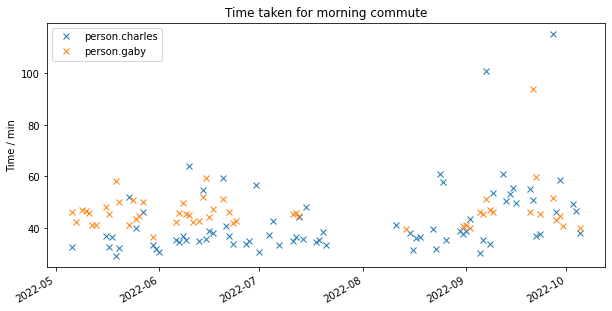

In [8]:
for person, data in journeys.items():
    data.index = data.index.round("D")
    journeys[person] = data[~data.index.duplicated()]
journeys = pd.DataFrame(journeys)
(journeys / pd.Timedelta("1m")).plot(
    ylabel="Time / min",
    title="Time taken for morning commute",
    style='x'
)

In [9]:
def extract_journey_times(results, person, from_place, to_place, plot=True):
    journeys = pd.Series(dtype='interval')
    
    state_changes = results.loc[results.entity_id == person, 'state']
    for i in range(state_changes.shape[0]):
        if state_changes.iloc[i] == from_place:
            try:
                for j in range(i+1, i+10):                
                    if state_changes.iloc[j] == to_place:
                        time_taken = state_changes.index[j] - state_changes.index[i+1]
                        journeys[state_changes.index[i+1]] = time_taken
                        break
            except IndexError:
                break
                
    journeys = journeys[(pd.Timedelta("20m") < journeys) & (journeys < pd.Timedelta("2h"))]
    

    journeys.index = journeys.index.round("D")
    journeys = journeys[~journeys.index.duplicated()]
    
    if plot:
        (journeys / pd.Timedelta("1m")).plot(
            ylabel="Time / min",
            title="Time taken for commute",
            style='x'
        )
    
    return journeys    

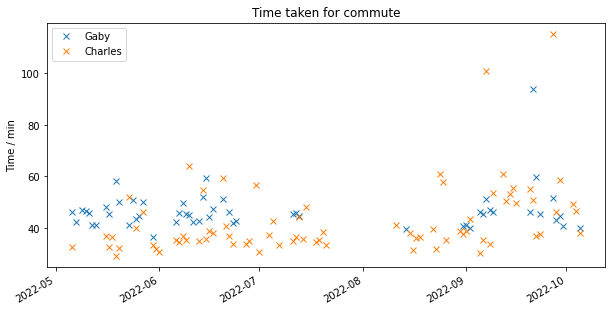

In [10]:
extract_journey_times(results, "person.gaby", "home", "Harris Westminster");
extract_journey_times(results, "person.charles", "home", "Imperial");
plt.legend(("Gaby", "Charles"));

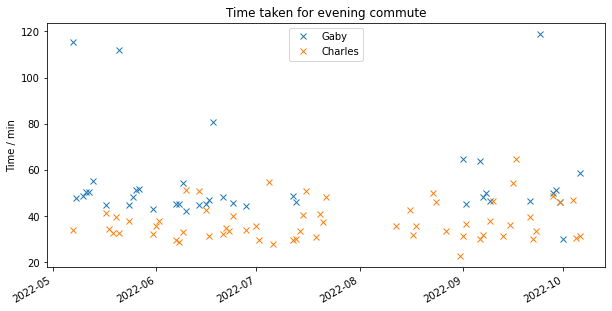

In [11]:
extract_journey_times(results, "person.gaby", "Harris Westminster", "home")
extract_journey_times(results, "person.charles", "Imperial", "home")
plt.title("Time taken for evening commute")
plt.legend(("Gaby", "Charles"));

In [12]:
journeys_evening = extract_journey_times(results, "person.charles", "Imperial", "home", plot=False)
journeys_evening['2022-02-09']

KeyError: '2022-02-09'

Huh?

In [ ]:
results.loc[results.entity_id=='person.charles']['2022-02-08':'2022-02-10']

Something funny in the data there, but the processing is fine. Chalk that one down to GPS logging noise. 

More filtering
===============

At some point, I added Wimbledon as a location so that I could distuinguish between train and bike journeys. When was this?

In [ ]:
d_start = results[results.state == "Wimbledon"].iloc[0].name
d_start

In [ ]:
d_start = results[results.state == "Wimbledon"].iloc[0].name
filtered_results = results[d_start : ]
filtered_results

In [ ]:
def extract_filtered_journey_times(results, person, from_place, to_place, via_place=None, not_via_place=None, plot=True):
    class Skip(Exception):
        pass
    
    journeys = pd.Series(dtype='interval')
    
    state_changes = results.loc[results.entity_id == person, 'state']
    for i in range(state_changes.shape[0]):
        if state_changes.iloc[i] == from_place:
            try:
                j = i+1
                if via_place:
                    while (True):
                        if state_changes.iloc[j] == via_place:
                            break
                        if not_via_place and state_changes.iloc[j] == not_via_place:
                            raise Skip
                        j = j + 1
                
                while (True):
                    if state_changes.iloc[j] == to_place:
                        break
                    if not_via_place and state_changes.iloc[j] == not_via_place:
                        raise Skip
                    j = j + 1
                            
                time_taken = state_changes.index[j] - state_changes.index[i+1]
                journeys[state_changes.index[i+1]] = time_taken
            except (IndexError, Skip):
                continue
                
    journeys = journeys[(pd.Timedelta("20m") < journeys) & (journeys < pd.Timedelta("2h"))]
    

    journeys.index = journeys.index.round("D")
    journeys = journeys[~journeys.index.duplicated()]
    
    if plot:
        (journeys / pd.Timedelta("1m")).plot(
            ylabel="Time / min",
            title="Time taken for commute",
            style='x'
        )
    
    return journeys

journeys = pd.DataFrame({"person":[], "commute": [], "vehicle": [], "time": []})

In [ ]:
journeys_train = extract_filtered_journey_times(results, "person.charles", "home", "Imperial", via_place="Wimbledon", plot=True)
journeys_bike = extract_filtered_journey_times(results, "person.charles",  "home", "Imperial", not_via_place="Wimbledon", plot=True)

journeys = journeys.append(pd.DataFrame({
    "person":"Charles",
    "commute": "Morning",
    "vehicle": "Train",
    "time": journeys_train
}))
journeys = journeys.append(pd.DataFrame({
    "person":"Charles",
    "commute": "Morning",
    "vehicle": "Bike",
    "time": journeys_bike
}))

plt.legend([
    f'Train journeys (median = {journeys_train.median().round("1s")})',
    f'Bike journeys (median = {journeys_bike.median().round("1s")})',
])
plt.title("Charles morning commutes");

In [ ]:
journeys_train = extract_filtered_journey_times(results, "person.charles", "Imperial", "home", via_place="Wimbledon", plot=True)
journeys_bike = extract_filtered_journey_times(results, "person.charles", "Imperial", "home", not_via_place="Wimbledon", plot=True)

journeys = journeys.append(pd.DataFrame({
    "person":"Charles",
    "commute": "Evening",
    "vehicle": "Train",
    "time": journeys_train
}))
journeys = journeys.append(pd.DataFrame({
    "person":"Charles",
    "commute": "Evening",
    "vehicle": "Bike",
    "time": journeys_bike
}))

plt.legend([
    f'Train journeys (median = {journeys_train.median().round("1s")})',
    f'Bike journeys (median = {journeys_bike.median().round("1s")})',
])
plt.title("Charles evening commutes");

In [ ]:
journeys_train = extract_filtered_journey_times(results, "person.gaby", "home", "Harris Westminster", via_place="Wimbledon", plot=True)
journeys_bike = extract_filtered_journey_times(results, "person.gaby",  "home", "Harris Westminster", not_via_place="Wimbledon", plot=True)

journeys = journeys.append(pd.DataFrame({
    "person":"Gaby",
    "commute": "Morning",
    "vehicle": "Train",
    "time": journeys_train
}))
journeys = journeys.append(pd.DataFrame({
    "person":"Gaby",
    "commute": "Morning",
    "vehicle": "Bike",
    "time": journeys_bike
}))

plt.legend([
    f'Train journeys (median = {journeys_train.median().round("1s")})',
    f'Bike journeys (median = {journeys_bike.median().round("1s")})',
])
plt.title("Gaby morning commutes");

In [ ]:
journeys_train = extract_filtered_journey_times(results, "person.gaby", "Harris Westminster", "home", via_place="Wimbledon", plot=True)
journeys_bike = extract_filtered_journey_times(results, "person.gaby", "Harris Westminster", "home", not_via_place="Wimbledon", plot=True)

journeys = journeys.append(pd.DataFrame({
    "person":"Gaby",
    "commute": "Evening",
    "vehicle": "Train",
    "time": journeys_train
}))
journeys = journeys.append(pd.DataFrame({
    "person":"Gaby",
    "commute": "Evening",
    "vehicle": "Bike",
    "time": journeys_bike
}))

plt.legend([
    f'Train journeys (median = {journeys_train.median().round("1s")})',
    f'Bike journeys (median = {journeys_bike.median().round("1s")})',
])
plt.title("Gaby evening commutes");

In [ ]:
journeys['duration'] = journeys.index
journeys = journeys.set_index(['person', 'commute', 'vehicle', 'duration'])
journeys = journeys / np.timedelta64(1, 'm')

In [ ]:
keys = [
    ('Charles', 'Morning', 'Train'),
    ('Charles', 'Evening', 'Train'),
    ('Charles', 'Morning', 'Bike'),
    ('Charles', 'Evening', 'Bike'),
    ('Gaby', 'Morning', 'Train'),
    ('Gaby', 'Evening', 'Train'),
    ('Gaby', 'Morning', 'Bike'),
    ('Gaby', 'Evening', 'Bike'),
]


d = {
    " ".join(key + (f"median = {journeys.loc[key, :].squeeze().median():.1f}",)): journeys.loc[key, :].squeeze()
for key in keys}

plt.rcParams['figure.figsize'] = [20, 10]

pd.DataFrame(d).plot.hist(subplots=True, layout=(2,4), sharex=True, grid=True)
plt.xlabel("time / min");

In [ ]:
g = pd.DataFrame(d).iloc[:, -1].squeeze()
g = g[g < 65]
g.plot.hist()